In [11]:
#!/usr/bin/env python

#comment out if not using jupyter
%matplotlib inline 

#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st


In [28]:
gene=['Gag','Env'][0]

#import data
df=pd.read_csv('data/053119_Proportions_'+gene+'.csv')
dfseed=pd.read_csv('data/HIV_DNA_Seeding_Timepoint_'+gene+'.csv')

df.head()

,Unnamed: 0,ID,Years_Post_Infection,Nucleic_Acid,IIorSI,Proportion_Each,YearsToSI,ARTInitiation,YearsSinceART,Viral Load c/mL
0,5,QB045,0.00,RNA,Initial,1.0,4.91,19.77,-19.77,949600
1,8,QB045,0.00,RNA,Superinfection,0.0,4.91,19.77,-19.77,949600
2,9,QB045,0.00,RNA,Recombinant,0.0,4.91,19.77,-19.77,949600
3,7,QB045,1.21,RNA,Superinfection,0.0,4.91,19.77,-18.56,20730
4,19,QB045,1.21,RNA,Recombinant,0.0,4.91,19.77,-18.56,20730


In [29]:
IDs=['QG262', 'QC885', 'QF564', 'QB726', 'QD022', 'QB045'] #put them in order of rest of paper
#IDs=set(df['ID']) #participant IDs
vts=['Initial', 'Superinfection', 'Recombinant'] #virus types

cz=['blue','red','lime'] #colors for initial, recombinant, superinfection


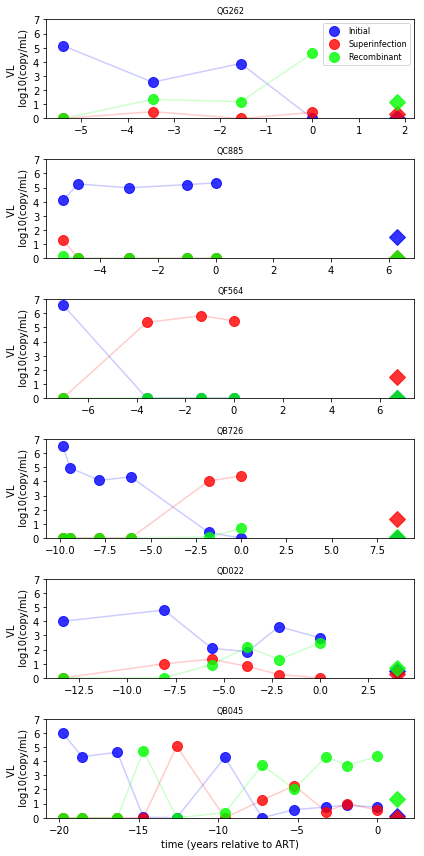

In [30]:
#looking at superinfection dynamics (selective sweeps)
plt.figure(figsize=(6,12))

#plot viral load and population sweeps
pind=0
for i in IDs:
    ax1=plt.subplot(611+pind)
    ax1.set_ylabel('VL \n log10(copy/mL)')
    ax1.set_ylim([0,7])
    ax1.set_yticks(range(8))
    cind=0
    for v in vts:
        tdf=df.loc[(df['ID'] == i) & (df['IIorSI'] == v)] #temporary data frame
        t=tdf['YearsSinceART']
        VL=tdf['Proportion_Each']*np.log10(tdf['Viral Load c/mL']+30)
        prop=tdf['Proportion_Each']
        ax1.plot(t[:-1],VL[:-1],color=cz[cind],ls='-',alpha=0.2)
        ax1.plot(t[:-1],VL[:-1],color=cz[cind],ls='',marker='o',markersize=10,alpha=0.8,label=v)
        ax1.plot(t[-1:],VL[-1:],color=cz[cind],ls='',marker='D',markersize=12,alpha=0.8)
        cind+=1
    ax1.set_title(i,fontsize=8)
    if pind==0:
        ax1.legend(fontsize=8,loc=1)
    if pind==5:
        ax1.set_xlabel('time (years relative to ART)')
        
    pind+=1
plt.tight_layout()
plt.savefig('figures/'+gene+'VLs.pdf',dpi=600)
    

In [15]:
#calculate 2 models of superinfected proportions

thL=5.2e-4*365 #the QVOA clearance rate
        
modelISR=[]
for i in IDs:
    DNA=[]; cumu=[]; last=[]
    for v in vts:
        tdfR=df.loc[(df['ID'] == i) & (df['IIorSI'] == v) & (df['Nucleic_Acid'] == 'RNA')] #temporary data frame
        tdfD=df.loc[(df['ID'] == i) & (df['IIorSI'] == v) & (df['Nucleic_Acid'] == 'DNA')] #temporary data frame
        
        tpre=np.array(tdfR['YearsSinceART'])
        tpost=float(tdfD['YearsSinceART'])
        
        DNA.append(float(tdfD['Proportion_Each']))
        
        #VL=tdfR['Proportion_Each']*np.log10(tdfR['Viral Load c/mL']+30)

        cumu.append(np.sum(tdfR['Proportion_Each']*tdfR['Viral Load c/mL']*np.exp(-thL*(-tpre+tpost))))
        last.append(np.array(tdfR['Proportion_Each'])[-1])#*np.array(tdfR['Viral Load c/mL'])[-1]*np.exp(-thL*(-tpre[-1]+tpost)))
        
        #last.append(np.array(tdfR['Proportion_Each'])[-1]*np.array(tdfR['Viral Load c/mL'])[-1]*np.exp(-thL*(-tpre[-1]+tpost)))

    m1=list(cumu/np.sum(cumu)) #model 1, the cumulative
    m2=list(last/np.sum(last)) #model 2, the last time point

    modelISR.append([i,'DNA']+DNA)
    modelISR.append([i,'cumulative']+m1)
    modelISR.append([i,'last-time']+m2)

#make the dataframe
df_model=pd.DataFrame(modelISR,columns=['pat_id','data','prop_I','prop_S','prop_R'])

#print csv
pd.DataFrame.to_csv(df_model,'data/'+gene+'_model_ISR.csv')

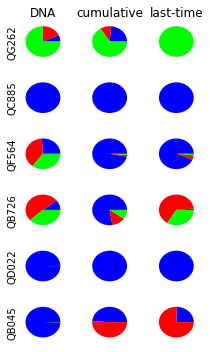

In [16]:
#now plot pie charts of data and models
plt.figure(figsize=(3,5))
pind=0
for i in IDs:
    dind=0
    for dt in df_model['data'].unique():
        tdf1=df_model[df_model['pat_id']==i]
        tdf2=tdf1[tdf1['data']==dt]
        
        plt.subplot(6,3,pind*3+dind+1)
        plt.pie(np.array(tdf2.iloc[:,2:5])[0],colors=cz,)
        if pind==0:
            plt.title(dt)
        if dind==0:
            plt.ylabel(i)
        dind+=1
    pind+=1
    
plt.tight_layout()
plt.savefig('figures/'+gene+'_allpies.pdf',dpi=600)


In [17]:
df_model

,pat_id,data,prop_I,prop_S,prop_R
0,QG262,DNA,0.068123,0.181678,0.750199
1,QG262,cumulative,0.235373,0.102511,0.662116
2,QG262,last-time,0.000000,0.000000,1.000000
3,QC885,DNA,1.000000,0.000000,0.000000
4,QC885,cumulative,1.000000,0.000000,0.000000
5,QC885,last-time,1.000000,0.000000,0.000000
6,QF564,DNA,0.259950,0.387952,0.352099
7,QF564,cumulative,0.970952,0.018619,0.010429
8,QF564,last-time,0.936948,0.046470,0.016581
9,QB726,DNA,0.105376,0.510916,0.383708


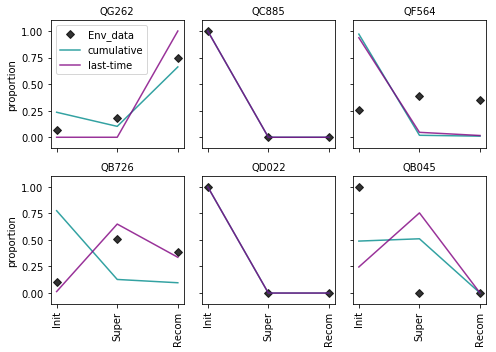

In [18]:
#compare models with lines and dots

fig,axarr=plt.subplots(2,3,figsize=(7,5),sharex=True,sharey=True)
#plot viral load and population sweeps
ind=0
modelz=[]
tpz=[]
for i in IDs:
    dind=0
    
    tdf1=df_model[df_model['pat_id']==i]

    DNA=np.array(tdf1[tdf1['data']=='DNA'].iloc[:,2:5])[0]
    m1=np.array(tdf1[tdf1['data']=='cumulative'].iloc[:,2:5])[0]
    m2=np.array(tdf1[tdf1['data']=='last-time'].iloc[:,2:5])[0]
    
    ax=axarr[int(ind/3)][ind%3]

    ax.plot(np.arange(3),DNA,color='k',marker='D',ls='',alpha=0.8,label=gene+'_data')
    ax.plot(np.arange(3),m1,color='darkcyan',alpha=0.8,label='cumulative')
    ax.plot(np.arange(3),m2,color='purple',alpha=0.8,label='last-time')

    modelz.append([np.sqrt(np.mean((DNA-m1)**2)),np.sqrt(np.mean((DNA-m2)**2))])
    tpz.append([-tpre[0],tpost])

    ax.set_title(i,fontsize=10)
    ax.set_xticks(range(3))
    ax.set_yticks(np.linspace(0,1,5))
    ax.set_xticklabels(['Init','Super','Recom'],rotation=90)
    ax.set_ylim([-0.1,1.1])
    plt.tight_layout()
    ind+=1
axarr[0][0].set_ylabel('proportion')
axarr[1][0].set_ylabel('proportion')
axarr[0][0].legend()#bbox_to_anchor=(1.1,1.))
plt.tight_layout()
plt.savefig('figures/'+gene+'_ISRmodel.pdf',dpi=600)
      

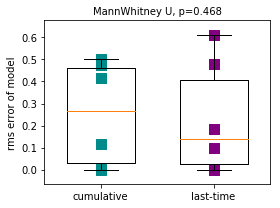

In [19]:
plt.figure(figsize=(4,3))
modelz=np.array(modelz)
plt.scatter(np.zeros(len(modelz))+2,modelz[:,1],marker='s',color='purple',s=100)#,label='last-time')
plt.scatter(np.zeros(len(modelz))+1,modelz[:,0],marker='s',color='darkcyan',s=100)#,label='cumulative')
plt.boxplot(modelz,widths=0.6)

plt.ylabel('rms error of model')
plt.xticks([1,2],['cumulative','last-time'])
#plt.xlabel('model')

plt.title('MannWhitney U, p='+str(np.round(st.mannwhitneyu(modelz[:,0],modelz[:,1])[1],3)),fontsize=10)
plt.tight_layout()
plt.savefig('figures/'+gene+'_ISRmodelcomp.pdf',dpi=600)


In [20]:
#see if there's an explanation for why last time works better (clinically)
ytART=[]; ytSI=[]
for i in IDs:
    tdf=df.loc[(df['ID'] == i)] #temporary data frame
    ytART.append(tdf['ARTInitiation'].iloc[0])
    ytSI.append(tdf['YearsToSI'].iloc[0])
    
ytART=np.array(ytART)
ytSI=np.array(ytSI)
    
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.scatter(ytART,modelz[:,0],marker='s',color='darkcyan',s=100,
            label='cumulative, p='+str(round(st.linregress(ytART,modelz[:,0])[3],3)))
plt.scatter(ytART,modelz[:,1],marker='s',color='purple',s=100,
            label='last-time, p='+str(round(st.linregress(ytART,modelz[:,1])[3],3)))
plt.xlabel('time pre ART (years post infection)')
plt.legend(loc=1)
plt.ylabel('rms error')
plt.ylim([-0.1,1])

plt.subplot(132)
plt.scatter(ytSI,modelz[:,0],marker='s',color='darkcyan',s=100,label='cumulative, p='+str(round(st.linregress(ytSI,modelz[:,0])[3],3)))
plt.scatter(ytSI,modelz[:,1],marker='s',color='purple',s=100,label='last-time, p='+str(round(st.linregress(ytSI,modelz[:,1])[3],3)))
plt.xlabel('time of SI (years post infection)')
plt.legend(loc=1)
plt.ylim([-0.1,1])

plt.subplot(133)
plt.scatter(ytART-ytSI,modelz[:,0],marker='s',color='darkcyan',s=100,
            label='cumulative, p='+str(round(st.linregress(ytART-ytSI,modelz[:,0])[3],3)))
plt.scatter(ytART-ytSI,modelz[:,1],marker='s',color='purple',s=100,
            label='last-time, p='+str(round(st.linregress(ytART-ytSI,modelz[:,1])[3],3)))
plt.xlabel('time of SI (years before ART)')
plt.ylim([-0.1,1])
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('figures/'+gene+'_ISRmodelcomp_corrs.pdf',dpi=600)


KeyError: 'YearsToSI'